Zero-shot sentiment analysis of financial news tweets

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

In [ ]:
from datasets import load_dataset
data_files = {"train": "sent_train.csv", "test": "sent_valid.csv"}
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment", data_files=data_files)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9543
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
})

In [ ]:
sentiments = {
    0: "Bearish", 
    1: "Bullish", 
    2: "Neutral"
}


Distribution of Sentiments

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, 'Distribution of Labels')

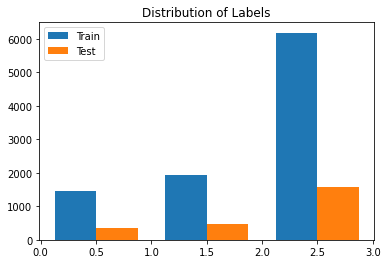

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

(n, bins, patches) = plt.hist( x = [np.asarray(dataset['train']['label']) , np.asarray(dataset['test']['label'])  ]
          , bins= [0,1,2,3]
         , align = 'mid'
         , rwidth = 0.75
         , histtype = 'bar'
         )

plt.legend(['Train','Test'])
plt.title('Distribution of Labels')

In [ ]:
# relative percentage of each label

n/np.sum(n, axis =1, keepdims = True)

array([[0.15110552, 0.20150896, 0.64738552],
       [0.14530988, 0.19891122, 0.65577889]])

# Zero-Shot Learning
Default model

[Link](https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment)

In [ ]:
train_rawdata = dataset["train"]
train_rawdata[0]

{'text': '$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT',
 'label': 0}

In [ ]:
train_rawdata[0]['text']

'$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT'

In [ ]:
from transformers import pipeline

sent_zsc =pipeline("zero-shot-classification")
ans = sent_zsc(train_rawdata[0]['text'],
                          candidate_labels = ['Bearish','Bullish','Neutral'])

In [ ]:
ans

{'sequence': '$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT',
 'labels': ['Bearish', 'Neutral', 'Bullish'],
 'scores': [0.49485671520233154, 0.3841414749622345, 0.12100183218717575]}

In [ ]:
# prediction with highest probability
ans['labels'][np.argmax(ans['scores'])]

'Bearish'

In [ ]:
sentiments[train_rawdata[0]['label']]

'Bearish'

In [ ]:
ans['labels'][np.argmax(ans['scores'])] == sentiments[train_rawdata[0]['label']]

True

In [ ]:
sent_zsc = pipeline("zero-shot-classification", model = 'facebook/bart-large-mnli')

In [ ]:
preds = sent_zsc(
    train_rawdata['text'][0:10]
    , candidate_labels =  [x for x in sentiments.values()]

)

In [ ]:
def compare(x):
  return x['labels'][np.argmax(x['scores'])] == sentiments[train_rawdata[0]['label']]

In [ ]:
for i in range(10):
  print(i, compare(preds[i]))

0 True
1 True
2 True
3 False
4 True
5 True
6 True
7 True
8 True
9 True


In [ ]:
x = preds[3]

print(x['sequence'])
print(x['labels'])
print(x['scores'])
print('prediction:',x['labels'][np.argmax(x['scores'])])
print('actual:',sentiments[train_rawdata[0]['label']])

$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N
['Neutral', 'Bearish', 'Bullish']
[0.9254097938537598, 0.06001339852809906, 0.014576745219528675]
prediction: Neutral
actual: Bearish


In [ ]:
test_rawdata = dataset["test"]
test_rawdata[0:10]

{'text': ['$ALLY - Ally Financial pulls outlook https://t.co/G9Zdi1boy5',
  '$DELL $HPE - Dell, HPE targets trimmed on compute headwinds https://t.co/YRUHZw7cYl',
  "$PRTY - Moody's turns negative on Party City https://t.co/MBD5TFGC4P",
  '$SAN: Deutsche Bank cuts to Hold',
  '$SITC: Compass Point cuts to Sell',
  '$TAP - Barclays cools on Molson Coors https://t.co/FJFsZWJHuH',
  '$TAP: Barclays cuts to Equal Weight',
  'Analysts Eviscerate Musk\'s Cybertruck: "0% Of Responses Felt It Will Be A Success" https://t.co/2NTzeZea4G',
  'Barclays assigns only a 20% chance that studies on a Gilead antiviral drug being done in China will succeed against… https://t.co/lIgDhy1Gli',
  "BTIG points to breakfast pressure for Dunkin' Brands"],
 'label': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
import re

def process_tweet(tweet):
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)

    return tweet

In [ ]:
test_data = [ process_tweet(twt) for twt in test_rawdata['text'] ]
#test_rawdata['label']
test_data[0:10]

[' - Ally Financial pulls outlook ',
 '  - Dell, HPE targets trimmed on compute headwinds ',
 " - Moody's turns negative on Party City ",
 ': Deutsche Bank cuts to Hold',
 ': Compass Point cuts to Sell',
 ' - Barclays cools on Molson Coors ',
 ': Barclays cuts to Equal Weight',
 'Analysts Eviscerate Musk\'s Cybertruck: "0% Of Responses Felt It Will Be A Success" ',
 'Barclays assigns only a 20% chance that studies on a Gilead antiviral drug being done in China will succeed against… ',
 "BTIG points to breakfast pressure for Dunkin' Brands"]

In [ ]:
idx0 = [idx for idx,lbl in enumerate(test_rawdata['label']) if test_rawdata['label'][idx] == 0]
idx1 = [idx for idx,lbl in enumerate(test_rawdata['label']) if test_rawdata['label'][idx] == 1]
idx2 = [idx for idx,lbl in enumerate(test_rawdata['label']) if test_rawdata['label'][idx] == 2]

In [ ]:
len(idx0) , len(idx1) , len(idx2)

(347, 475, 1566)

In [ ]:
n = 33
sample_idx= idx0[0:n] + idx1[0:n] + idx2[0:n] 


In [ ]:
sample_data = []
sample_label = []

for idx in sample_idx:
  sample_data.append(test_data[idx])
  sample_label.append(test_rawdata['label'][idx])

sample_data[0]

' - Ally Financial pulls outlook '

In [ ]:
preds = sent_zsc(
    sample_data
    , candidate_labels =  [x for x in sentiments.values()]
)

preds[-5]

{'sequence': 'Central banks don’t have as much monetary policy power as they used to, former BOE policy maker Ian McCafferty says ',
 'labels': ['Neutral', 'Bearish', 'Bullish'],
 'scores': [0.48675984144210815, 0.3307627737522125, 0.1824774295091629]}

In [ ]:
cnt = 0
idx_wrong = []
for i in range(len(sample_data)):
  if preds[i]['labels'][np.argmax(preds[i]['scores'])] == sentiments[sample_label[i]]:
    cnt +=1
  else:
    idx_wrong.append(i)

print(cnt/len(sample_data)*100, '% accuracy')
print(idx_wrong)

70.70707070707071 % accuracy


## Other models

Models


1. ProsusAI/finbert
2. finiteautomata/bertweet-base-sentiment-analysis
3. yiyanghkust/finbert-tone
4. cardiffnlp/twitter-roberta-base-sentiment
5. mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis
6. soleimanian/financial-roberta-large-sentiment
7. ahmedrachid/FinancialBERT-Sentiment-Analysis
8. nickmuchi/finbert-tone-finetuned-fintwitter-classification (*yiyanghkust/finbert-tone tuned on this dataset*)











In [ ]:
models = ['ProsusAI/finbert'
    , 'finiteautomata/bertweet-base-sentiment-analysis'
    , 'yiyanghkust/finbert-tone'
    , 'cardiffnlp/twitter-roberta-base-sentiment'
    , 'mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis'
    , 'soleimanian/financial-roberta-large-sentiment'
    , 'ahmedrachid/FinancialBERT-Sentiment-Analysis'
    , 'nickmuchi/finbert-tone-finetuned-fintwitter-classification'
]

In [ ]:
#can't use above models with zero shot as they are not trained for that
#need to use them for sentiment classification using TFAutoModel (with/out fine tuning)
